In [207]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [91]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [101]:
train_data = CIFAR10(root='./data/classification',train=True,download=True,transform=transform)
test_data = CIFAR10(root='./data/classification',train=False,download=True,transform=transform)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [02:13<00:00, 1275425.33it/s]


Extracting ./data/classification\cifar-10-python.tar.gz to ./data/classification
Files already downloaded and verified


In [103]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/classification
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
           )

In [105]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/classification
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
           )

In [107]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,64,shuffle=True)
test_loader = DataLoader(test_data,64,shuffle=False)

In [209]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,16,3,padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()        
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*8*8,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x): # x -> batch size * 3 *32 *32
        x = self.conv1(x)
        x = self.bn1(x)
        x=  self.relu(x)
        x=  self.pool(x) # batch size * 6 * 16 * 16
        x = self.conv2(x)
        x = self.bn2(x)
        x=  self.relu(x)
        x=  self.pool(x) # batch size * 6 * 8 * 8
        x = x.view(-1,16*8*8)
        # x=  self.dropout(x)
        x= self.fc1(x)
        x=  self.relu(x) # batch size * 120
        # x=  self.dropout(x)
        x= self.fc2(x)
        x=  self.relu(x) # batch size * 84
        x= self.fc3(x) # batch size * 10
        return x

In [129]:
model = CNN().to('cuda')
criterion = F.cross_entropy
optimizer = SGD(model.parameters(),lr=0.001,momentum=0.9, weight_decay=5e-4)
schedular = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [133]:
x = torch.rand(64,3,32,32,device='cuda')
model(x).size()

torch.Size([64, 10])

In [135]:
from tqdm import tqdm
for i in range(30):
    model.train()
    loop = tqdm(train_loader)
    for img,lbs in loop:
        img,lbs = img.to('cuda'),lbs.to('cuda')
        out = model(img)
        loss = criterion(out,lbs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    schedular.step()

100%|████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.34it/s, loss=0.719]


In [139]:
corr = 0
total = 0
model.eval()
for img,lbs in test_loader:
    img,lbs = img.to('cuda'),lbs.to('cuda')
    out = model(img)
    _,pred = torch.max(out.data,1)
    corr += (pred == lbs).sum().item()
    total += lbs.size(0)
accuracy = 100*corr/total
print(f"correct : {corr}/{total}, accuracy : {accuracy}")    

correct : 6467/10000, accuracy : 64.67


In [179]:
test = {
    "images": [],
    "labels": []
}
for img,lbs in test_loader:
    for im in img:
        test['images'].append(im)
    for lb in lbs:
        test['labels'].append(lb)

In [181]:
test_df = pd.DataFrame(test)
test_df.head()

,images,labels
0,"[[[tensor(-1.9895), tensor(-1.9895), tensor(-1...",tensor(3)
1,"[[[tensor(1.7575), tensor(1.7416), tensor(1.74...",tensor(8)
2,"[[[tensor(-1.9895), tensor(-1.9895), tensor(-1...",tensor(8)
3,"[[[tensor(-1.9895), tensor(-1.9895), tensor(-1...",tensor(0)
4,"[[[tensor(-1.9895), tensor(-1.9895), tensor(-1...",tensor(6)


In [185]:
test_df['images'][0].size()

torch.Size([3, 32, 32])

In [163]:
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.247, 0.243, 0.261])

original : 8 
predict : tensor([8], device='cuda:0')


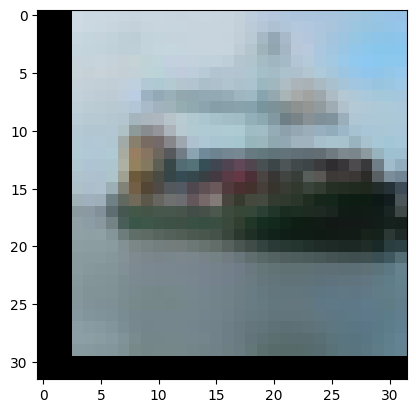

In [217]:
index = 1101
out = model((test_df['images'][index].to('cuda')).unsqueeze(0))
_,pred = torch.max(out,1)
print(f"original : {test_df['labels'][index]} \npredict : {pred}")
np_img = (test_df['images'][index]*std.view(3, 1, 1) + mean.view(3, 1, 1)).numpy()
plt.imshow(np.transpose(np_img,(1,2,0)))
plt.show()